In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses
import tensorflow_datasets  as tfds

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import random

from datetime import datetime
import itertools

In [2]:
# Print the list of available devices
print(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Detect and Initialize the GPUs
strategy = tf.distribute.MirroredStrategy()
!nvidia-smi

print("GPUs initialized.")

Fri Mar 24 19:55:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W /  70W |  14060MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Hyperparameters

In [4]:
N_REPLICAS = strategy.num_replicas_in_sync
print(f"Number of available replicas: {N_REPLICAS}")

Number of available replicas: 2


In [5]:
IMAGE_SIZE = (128, 128)
EPOCHS = 100
BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * N_REPLICAS 
EARLY_STOP_PATIENCE = 7

# Number of classes to segment the image to
N_CLASSES = 3

# Define the colormap for plotting the segmented images
COLORS = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]        # Red, Green, Blue
assert len(COLORS) == N_CLASSES
MASK_CMAP = matplotlib.colors.ListedColormap(COLORS)

# Helper Class

In [6]:
class Helper:
    @staticmethod
    def resize(images, target_size):
        return tf.image.resize(images, target_size, method='bilinear')
    
    @staticmethod
    def augment(image, mask, probability=0.2):
        do_flip = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float32) < probability
        
        if do_flip:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        
        return image, mask
    
    @staticmethod
    def preprocess(instance, target_size=IMAGE_SIZE, augment=False):
        image, mask = instance['image'], instance['segmentation_mask']

        # Resize the image
        image = Helper.resize(image, target_size)
        mask = Helper.resize(mask, target_size)
        
        # Augment the images randomly
        if augment:
            image, mask = Helper.augment(image, mask)
        
        # Normalize the images
        image = (tf.cast(image, tf.float32) - 127.5) / 127.5
        
        # Map classes 1, 2, 3 to classes 0, 1, 2 
        mask = mask - 1
        
        return image, mask
    
    @staticmethod
    def plot(images, cmap=MASK_CMAP, titles=None, fig_size=(10, 10), is_BGR=True, n_cols=7):
        """
        This method allows you to display a collection of images in a grid, with titles for each image.

        Parameters:
        - `images` (list): A list of images.
        - `titles` (list, optional): A list of strings, representing the title for each image. The length of `titles` should be equal to the length of `images`.
        - `fig_size` (tuple): The size of the figure.
        - `is_BGR` (bool, optional): Indicates whether the input images are in BGR format (default is True).
        - `n_cols` (int, optional): The number of columns in the grid (default is 3).

        Returns:
        None
        """

        # Check if the images and the titles have the same length
        if titles is not None and len(images) != len(titles):
            raise ValueError("Images and titles must have the same length")

        # Calculate the number of rows required for the figure
        n_rows = int(np.ceil(len(images) / n_cols))

        # Create the fig
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)

        for ax, img, title in itertools.zip_longest(axes.flat, images, titles or []):
            if is_BGR:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ax.imshow(img, cmap=cmap)
            if titles is not None:
                ax.set_title(title)

            # Remove the tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        fig.tight_layout()
        

# Loading the Dataset

In [7]:
# Load and split the Oxford-IIIT Pets dataset
(train_data, test_data), info = tfds.load("oxford_iiit_pet", split=['train', 'test'], with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0NZOWY/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0NZOWY/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [8]:
# Preprocess
train_data = train_data.map(lambda i : Helper.preprocess(i, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(lambda i : Helper.preprocess(i, augment=False), num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
# Convert to batched dataset
train_data = train_data.cache().batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

test_data = test_data.cache().batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Data Visualization

23


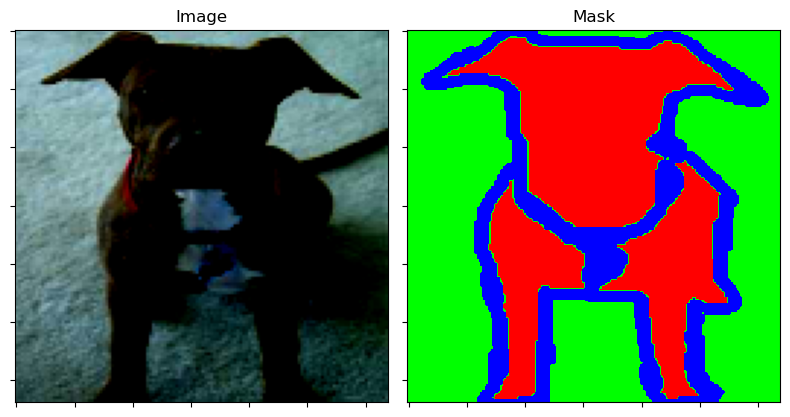

In [10]:
random_index = int(tf.random.uniform(shape=[], minval=1, maxval=BATCH_SIZE, dtype=tf.int32))
print(random_index)

batch = next(iter((train_data)))
image, mask = batch[0][random_index], batch[1][random_index]
Helper.plot([image, mask], cmap=MASK_CMAP, titles=['Image', 'Mask'], fig_size=(8,8), is_BGR=False, n_cols=2)

# Building the Model

### Model architecture based on https://arxiv.org/abs/1505.04597

In [11]:
def downsample_block(inputs, filters, kernel_size=3, padding='same', strides=1):
    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False, kernel_initializer = "he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False, kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    
    return x

def upsample_block(inputs, filters, skip_connection, kernel_size=3, padding='same', strides=1):
    x = layers.UpSampling2D()(inputs)
    x = layers.Concatenate(axis=-1)([x, skip_connection])
    
    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(filters, kernel_size, strides, padding, activation='relu', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    
    return x

def build_UNet(input_shape=(*IMAGE_SIZE, 3), n_output_channels=N_CLASSES):
    input_layer = layers.Input(shape=input_shape)
    
    # Encoder
    # 128 x 128 => 64 x 64
    down1 = downsample_block(inputs=input_layer, filters=64)
    pool1 = layers.MaxPooling2D((2, 2))(down1)
    
    # 64 x 64 => 32 x 32
    down2 = downsample_block(inputs=pool1, filters=128)
    pool2 = layers.MaxPooling2D((2, 2))(down2)
    
    # 32 x 32 => 16 x 16
    down3 = downsample_block(inputs=pool2, filters=256)
    pool3 = layers.MaxPooling2D((2, 2))(down3)
    
    # 16 x 16 => 8 x 8
    down4 = downsample_block(inputs=pool3, filters=512)
    pool4 = layers.MaxPooling2D((2, 2))(down4)
    
    # Final convolutional layer
    encoder_outputs = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(pool4)
    
    # Decoder
    # 8 x 8 => 16 x 16
    up4 = upsample_block(inputs=pool4, filters=512, skip_connection=down4)
    
    # 16 x 16 => 32 x 32
    up3 = upsample_block(inputs=up4, filters=256, skip_connection=down3)
    
    # 32 x 32 => 64 x 64
    up2 = upsample_block(inputs=up3, filters=128, skip_connection=down2)
    
    # 64 x 64 => 128 x 128
    up1 = upsample_block(inputs=up2, filters=64, skip_connection=down1)
    
    # Output
    decoder_outputs = layers.Conv2D(n_output_channels, (1, 1), strides=1, activation='softmax')(up1)
    
    # Create the model
    model = keras.models.Model(inputs=[input_layer], outputs=[decoder_outputs], name="U-Net")
    
    return model

In [12]:
# Build and compile the model
with strategy.scope():
    model = build_UNet(input_shape=(*IMAGE_SIZE, 3), 
                       n_output_channels=N_CLASSES)
    
    model.compile(optimizer=optimizers.Adam(),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics='accuracy')

# Print the model's summary
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

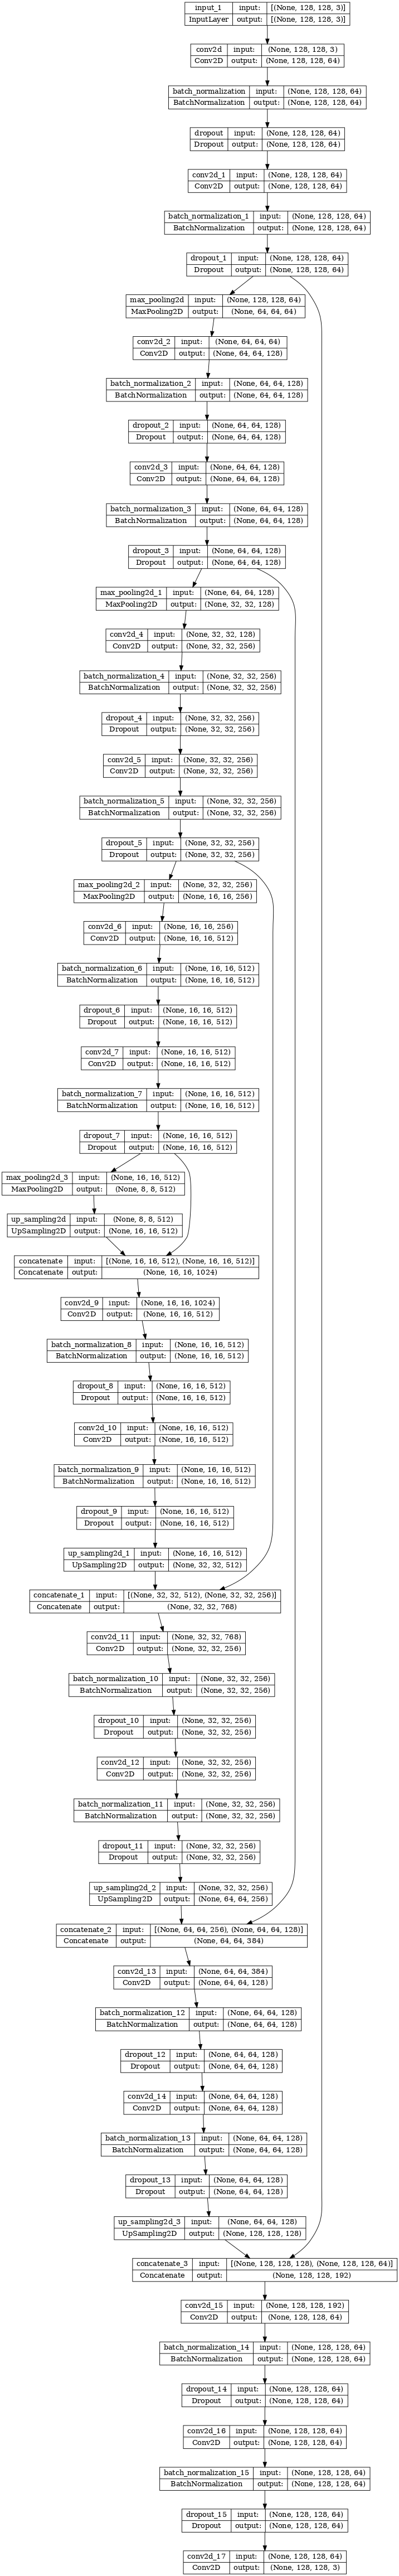

In [13]:
# Plot the model's architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=65)

# Training

In [14]:
# Stop training if the model doesn't improve for 7 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=EARLY_STOP_PATIENCE,
                                              restore_best_weights=True,
                                              verbose=1
                                             )

# Train the model
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=EPOCHS,
                    callbacks=[early_stop]
                   )

# Save the model
model.save(f"{datetime.now().strftime('%Y%m%d-%H%M%S')}-UNet.h5")

Epoch 1/100


2023-03-24 19:56:32.606650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 3/58 [>.............................] - ETA: 39s - loss: 1.6775 - accuracy: 0.3542

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


58/58 [==============================] - 98s 1s/step - loss: 0.8587 - accuracy: 0.6619 - val_loss: 8.4431 - val_accuracy: 0.6897
Epoch 2/100
58/58 [==============================] - 50s 874ms/step - loss: 0.5794 - accuracy: 0.7710 - val_loss: 4.3172 - val_accuracy: 0.6451
Epoch 3/100
58/58 [==============================] - 50s 860ms/step - loss: 0.4872 - accuracy: 0.8034 - val_loss: 1.8025 - val_accuracy: 0.7066
Epoch 4/100
58/58 [==============================] - 51s 874ms/step - loss: 0.4343 - accuracy: 0.8227 - val_loss: 4.0994 - val_accuracy: 0.6726
Epoch 5/100
58/58 [==============================] - 50s 868ms/step - loss: 0.4006 - accuracy: 0.8356 - val_loss: 2.0356 - val_accuracy: 0.6768
Epoch 6/100
58/58 [==============================] - 51s 881ms/step - loss: 0.3760 - accuracy: 0.8458 - val_loss: 1.4409 - val_accuracy: 0.7373
Epoch 7/100
58/58 [==============================] - 50s 862ms/step - loss: 0.3559 - accuracy: 0.8536 - val_loss: 1.8167 - val_accuracy: 0.6944
Epoch 8

# Evaluation

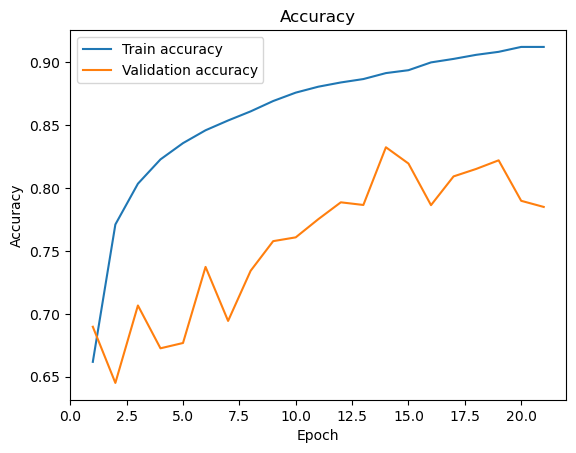

In [15]:
# Plot the accuracy curve
plt.plot(range(1, len(history.history['accuracy']) + 1),
         history.history['accuracy'],
         label="Train accuracy"
        )
plt.plot(range(1, len(history.history['val_accuracy']) + 1),
         history.history['val_accuracy'],
         label="Validation accuracy"
        )

plt.title("Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

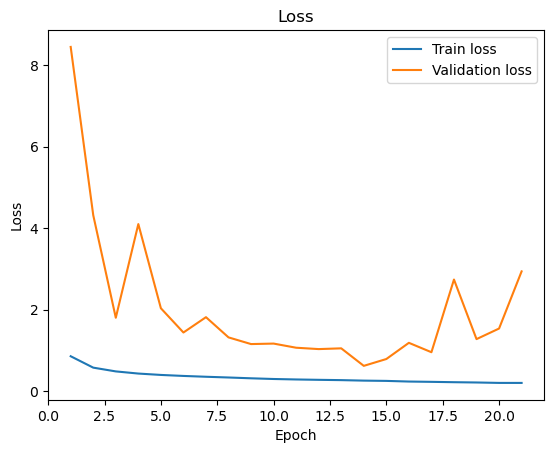

In [16]:
# Plot the loss curve
plt.plot(range(1, len(history.history['loss']) + 1),
         history.history['loss'],
         label="Train loss"
        )
plt.plot(range(1, len(history.history['val_loss']) + 1),
         history.history['val_loss'],
         label="Validation loss"
        )

plt.title("Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

1/1 [==============================] - 4s 4s/step


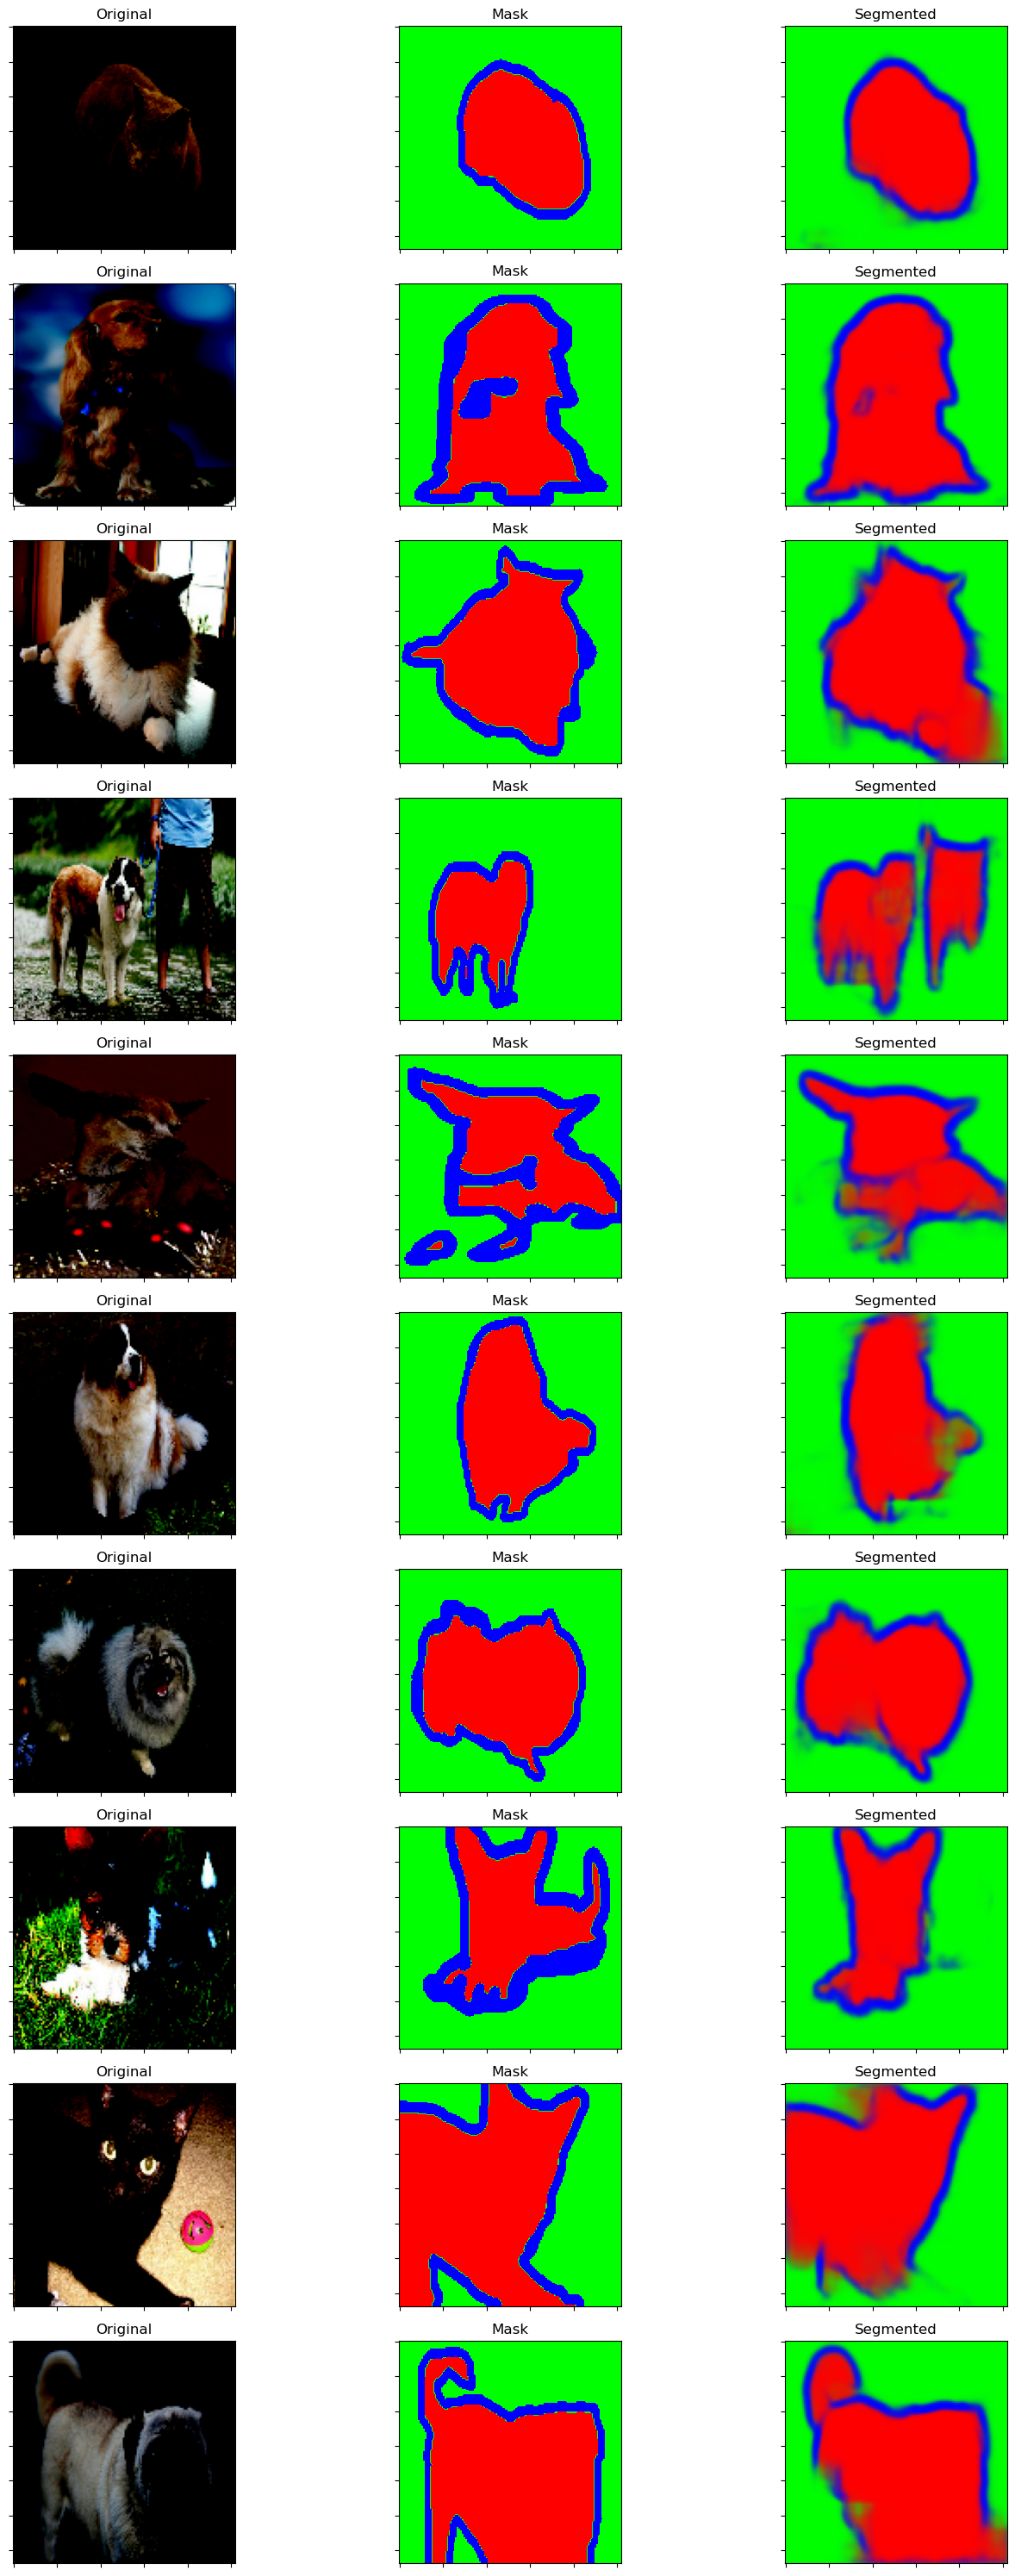

In [17]:
n_tests = 10

# Select a random batch
batch = next(iter(test_data.shuffle(1000)))

# Select 'n_tests' images to segment
images, masks = batch[0], batch[1]
images, masks = images[: n_tests], masks[: n_tests]

# Segment the selected images
segmentations = model.predict(images)

# Plot the segmented images
to_plot = []
titles = []
for image, mask, segmented in zip(images, masks, segmentations):
    to_plot.append(image)
    to_plot.append(mask)
    to_plot.append(segmented)
    
    titles.append('Original')
    titles.append('Mask')
    titles.append('Segmented')

Helper.plot(to_plot, titles=titles, cmap=MASK_CMAP, n_cols=3, is_BGR=False, fig_size=(15, 30))